# Data Processing
This notebook contains the code for processing the wildfire and AQI data, namely loading the wildfire data, filtering down based on our three part criteria (defined below),generating smoke estimates (metric also defined below) and comparing our smoke estimates to that of the AQI historical data.

## Importing Libraries

In [5]:
import json
import pandas as pd
import matplotlib.pyplot as plt

from pyproj import Transformer, Geod

#    The 'wildfire' module is a user module. 
#from wildfire.Reader import Reader as WFReader

## Loading the Data

In [2]:
with open("../data_intermediate/full_wildfires.json", "r") as file:
    full_wildfires_raw = json.load(file)

## Filter the wildfire data to include only relevant fires
Relevant fires are fires:

1.) That occured in the last 60 years of wildland fire data (1961-2021)

2.) That occured within the fire season of May 1st through October 31st

3.) Whose centroid is within 650 Miles of Norman, OK

In [3]:
# Filter to fires after 1961 
wildfires_post_1961 = [fire for fire in full_wildfires_raw if fire["attributes"]["Fire_Year"] >= 1961] #TODO update year

# Filter to something to do with fires in the fire season?
# TODO
wildfires_filtered = wildfires_post_1961



### Computing the average distance of the fire to Norman

In [4]:
### Helper Functions ###

#
#    Transform feature geometry data
#
#    The function takes one parameter, a list of ESRI:102008 coordinates that will be transformed to EPSG:4326
#    The function returns a list of coordinates in EPSG:4326
def convert_ring_to_epsg4326(ring_data=None):
    converted_ring = list()
    #
    # We use a pyproj transformer that converts from ESRI:102008 to EPSG:4326 to transform the list of coordinates
    to_epsg4326 = Transformer.from_crs("ESRI:102008","EPSG:4326")
    # We'll run through the list transforming each ESRI:102008 x,y coordinate into a decimal degree lat,lon
    for coord in ring_data:
        lat,lon = to_epsg4326.transform(coord[0],coord[1])
        new_coord = lat,lon
        converted_ring.append(new_coord)
    return converted_ring

#    
#    The function takes two parameters
#        A place - which is coordinate point (list or tuple with two items, (lat,lon) in decimal degrees EPSG:4326
#        Ring_data - a list of decimal degree coordinates for the fire boundary
#
#    The function returns the average miles from boundary to the place
#
def average_distance_from_place_to_fire_perimeter(place=None,ring_data=None):
    # convert the ring data to the right coordinate system
    ring = convert_ring_to_epsg4326(ring_data)    
    # create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps='WGS84')
    # create a list to store our results
    distances_in_meters = list()
    # run through each point in the converted ring data
    for point in ring:
        # calculate the distance
        d = geodcalc.inv(place[1],place[0],point[1],point[0])
        distances_in_meters.append(d[2])
    #print("Got the following list:",distances_in_meters)
    # convert meters to miles
    distances_in_miles = [meters*0.00062137 for meters in distances_in_meters]
    # the esri polygon shape (the ring) requires that the first and last coordinates be identical to 'close the region
    # we remove one of them so that we don't bias our average by having two of the same point
    distances_in_miles_no_dup = distances_in_miles[1:]
    # now, average miles
    average = sum(distances_in_miles_no_dup)/len(distances_in_miles_no_dup)
    return average

Compute the distances, and filter to only include fires within 650 miles of Norman

In [5]:
#Define Norman Location
norman = {'city'   : 'Norman',
        'latlon' : [35.24, -97.35] }

# Filter to only include fires where the average distance is within 650 miles of Norman, OK
wildfires_near_norman = []
for index, fire in enumerate(wildfires_filtered):
    if index % 10000 == 0:
        print(index)

    # Compute the Distance, if ring data exists
    if 'rings' in fire['geometry']:
        distance = average_distance_from_place_to_fire_perimeter(place=norman['latlon'],ring_data=fire['geometry']['rings'][0])
        #print(f"Fire '{fire['attributes']['Listed_Fire_Names'].split(',')[0]}' ({fire['attributes']['GIS_Acres']:1.2f} acres) from {fire['attributes']['Fire_Year']} was an average {distance:1.2f} miles to {norman['city']}")
        
        #Store the fire if it is within 650 miles
        if distance <= 650: 
            fire['attributes']['distance_from_norman'] = distance
            wildfires_near_norman.append(fire['attributes'])
    

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000


## Wildfire Smoke Estimates
Generate smoke estimates for Norman from all of the wildfires in our filtered dataset.

First, we assign a Smoke Contibution, "SC", score that is defined as the product of two normalized features, Distance Impact ("D") * Acreage Impact ("A")
#### SC = D * A

#### 1.) Distance Impact, "D"
The Distance Impact is defined as (650 - Miles from Norman)/650. All values in our dataset take a value between 0 and 1.

Here, we assume that a fire with a distance of 0 miles from Norman has the maximum impact, and therefore gets a "Distance Impact" of 1, while a fire on the outer boundary of our cutoff (at 650 miles) has a "Distance Impact" of 0. This formula assumes that there is a linear relationship between smoke contribution and distance from Norman, and that a fire past 650 miles has zero impact, both of which we know are likely not completely true, but we belive can make for useful simplifications.

#### 2.) Acreage Impact, "A"
The Acreage Impact is defined as (this_fire_acreage)/(max_fire_acreage). All values in our dataset take a value between 0 and 1.

Here, we assume that a fire with a the largest acreage has the maximum impact, and therefore gets a "Acreage Impact" of 1, while a fire with 0 acreage (i.e. not a fire) has a "Acreage Impact" of 0. Similar to above, this formula assumes that there is a linear relationship between smoke contribution and fire acreage.


Overall, this formula for smoke contribution makes a variety of simplifications and assumptions beyond just those listed above, including the assumption that fire duration has no impact on smoke, and additionally that fires from all directions have the same impact (but we don't have wind information, so not much we can do here).


In [6]:
#Define the smoke impace metric
def get_smoke_contribution(fire, max_acres):

    # Extract distance and compute Distance Impact
    distance = fire['distance_from_norman']
    d = (650 - distance)/650

    # Extract acreage and compute Acreage Impact
    acres = fire['GIS_Acres']
    a = acres/max_acres

    # Compute combined smoke impact
    sc = d*a
    
    return sc

In [7]:
# Compute Smoke Impact

# Find max acres
max_acres = max(wildfires_near_norman, key=lambda x: x["GIS_Acres"])["GIS_Acres"]

# Compute Smoke Impact for all of the fires, 
for index, fire in enumerate(wildfires_near_norman):
    wildfires_near_norman[index]['Smoke_Contribution'] = get_smoke_contribution(fire, max_acres)

print(json.dumps(wildfires_near_norman[8], indent=4))

{
    "OBJECTID": 13816,
    "USGS_Assigned_ID": 13816,
    "Assigned_Fire_Type": "Wildfire",
    "Fire_Year": 1961,
    "Fire_Polygon_Tier": 1,
    "Fire_Attribute_Tiers": "1 (1), 3 (1)",
    "GIS_Acres": 4.840703345537484,
    "GIS_Hectares": 1.9589631422821538,
    "Source_Datasets": "Comb_National_NIFC_Interagency_Fire_Perimeter_History (1), Comb_National_USFS_Final_Fire_Perimeter (1)",
    "Listed_Fire_Types": "Wildfire (2)",
    "Listed_Fire_Names": "No Fire Name Provided (2)",
    "Listed_Fire_Codes": "No code provided (2)",
    "Listed_Fire_IDs": "",
    "Listed_Fire_IRWIN_IDs": "",
    "Listed_Fire_Dates": "Listed Other Fire Date(s): 2018-05-02 - NIFC DATE_CUR field (1), 2018-05-02 - REVDATE field (1)",
    "Listed_Fire_Causes": "",
    "Listed_Fire_Cause_Class": "Undetermined (2)",
    "Listed_Rx_Reported_Acres": null,
    "Listed_Map_Digitize_Methods": "Digitized Other (1)",
    "Listed_Notes": "Digitized from historic fire atlases (2)",
    "Processing_Notes": "",
    "Wild

In [8]:
with open("../data_intermediate/norman_wildfires_SI.json", "w") as file: #TODO Change this when running the full dataset
    json.dump(wildfires_near_norman, file, indent=4)

## Yearly Smoke Estimate

To gain a better understanding of the smoke impact on Norman on a year-by-year basis, I will create a new dataset that contains the yearly smoke estimate. The yearly smoke estimate is computed by adding the smoke impact score (SI) of all of the wildfires that occured in a given year. Note that this assumes a cummulative impact, and does not account for periods of higher or lower frequency of fires. Although this analysis does miss out on some higher frequency time impacts, it is able to capture a simplistic and holistic estimatme of the total smoke on a year-by-year basis.

In [2]:
with open("../data_intermediate/norman_wildfires_SI.json", "r") as file: 
    wildfires_near_norman = json.load(file)

In [ ]:
# Initialize empty dictionary
yearly_smoke_estimate = {}

# Compute Smoke Impact for all of the fires, 
for index, fire in enumerate(wildfires_near_norman):
    if fire['Fire_Year'] in yearly_smoke_estimate:
        yearly_smoke_estimate[fire['Fire_Year']] += fire['Smoke_Contribution']
    else:
        yearly_smoke_estimate[fire['Fire_Year']] = fire['Smoke_Contribution']

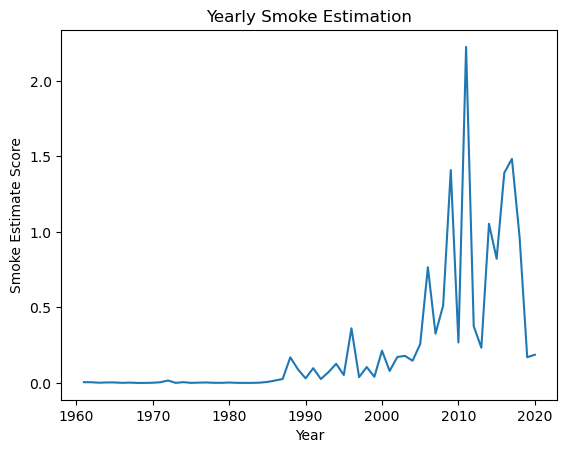

In [13]:
#Exploratory plotting of the smoke estimate
yearly_smoke_estimate_df = pd.DataFrame.from_dict(yearly_smoke_estimate, orient='index', columns=['Smoke_Estimate']).reset_index().rename(columns={'index':'Year'})

plt.plot(yearly_smoke_estimate_df['Year'], yearly_smoke_estimate_df['Smoke_Estimate'])
plt.title("Yearly Smoke Estimation")
plt.xlabel("Year")
plt.ylabel("Smoke Estimate Score")
plt.show()
